# Test clustering perfil viajero

In [3]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# Cargar y preparar datos
df = pd.read_csv("../Data/datos_INE_consolidados_17112025.csv")

# Crear dataset para clustering (agrupado por país-provincia)
df_perfiles = df.groupby(['pais_residencia', 'provincia']).agg({
    'media_pernoctaciones': 'mean',
    'total_viajeros': 'sum',
    'pernoctaciones': 'sum',
    'mes': 'count'  # número de meses con datos
}).reset_index()

# Calcular métricas adicionales para perfiles
df_perfiles['estancia_relativa'] = df_perfiles['media_pernoctaciones'] / df_perfiles['media_pernoctaciones'].mean()
df_perfiles['volumen_relativo'] = df_perfiles['total_viajeros'] / df_perfiles['total_viajeros'].mean()
df_perfiles['intensidad_visitas'] = df_perfiles['total_viajeros'] / df_perfiles['mes']

# Filtrar países/provincias con suficiente data
df_perfiles = df_perfiles[df_perfiles['total_viajeros'] > 1000]  # mínimo 1000 viajeros

print(f"Países-provincias para clustering: {len(df_perfiles)}")

Países-provincias para clustering: 202


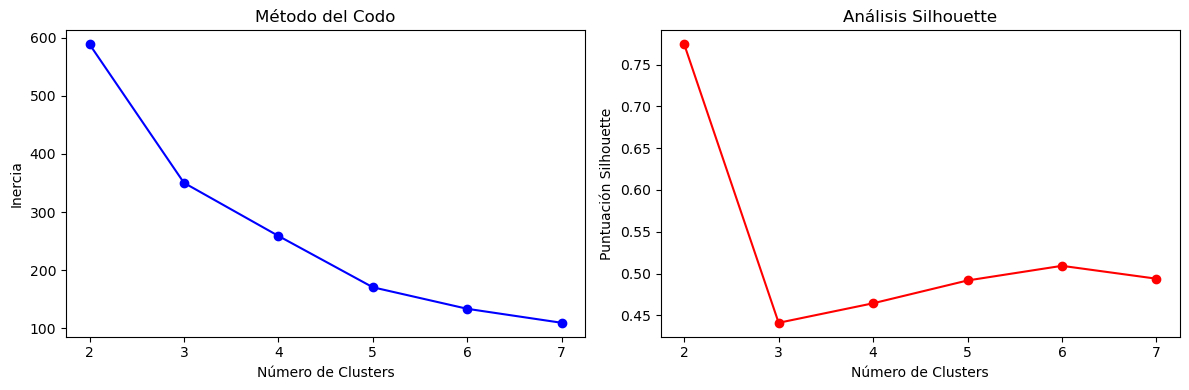

In [4]:
# Seleccionar características para clustering
features_clustering = [
    'media_pernoctaciones',
    'estancia_relativa', 
    'volumen_relativo',
    'intensidad_visitas',
    'pernoctaciones'
]

X_cluster = df_perfiles[features_clustering]

# Escalar características
scaler_cluster = StandardScaler()
X_scaled = scaler_cluster.fit_transform(X_cluster)

# Determinar número óptimo de clusters
inertia = []
silhouette_scores = []
k_range = range(2, 8)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Graficar método del codo y silhouette
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(k_range, inertia, 'bo-')
ax1.set_xlabel('Número de Clusters')
ax1.set_ylabel('Inercia')
ax1.set_title('Método del Codo')

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Número de Clusters')
ax2.set_ylabel('Puntuación Silhouette')
ax2.set_title('Análisis Silhouette')

plt.tight_layout()
plt.show()

In [5]:
# Elegir k basado en silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Número óptimo de clusters: {optimal_k}")

# Aplicar K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_perfiles['cluster'] = kmeans.fit_predict(X_scaled)

# Añadir centroides para interpretación
centroids = pd.DataFrame(
    scaler_cluster.inverse_transform(kmeans.cluster_centers_),
    columns=features_clustering
)
centroids['cluster'] = centroids.index

print("Centroides de cada cluster:")
print(centroids.round(2))

Número óptimo de clusters: 2
Centroides de cada cluster:
   media_pernoctaciones  estancia_relativa  volumen_relativo  \
0                  4.67               1.00              0.59   
1                  5.15               1.11             14.55   

   intensidad_visitas  pernoctaciones  cluster  
0             2947.42      1162539.18        0  
1            72642.97     28767341.67        1  


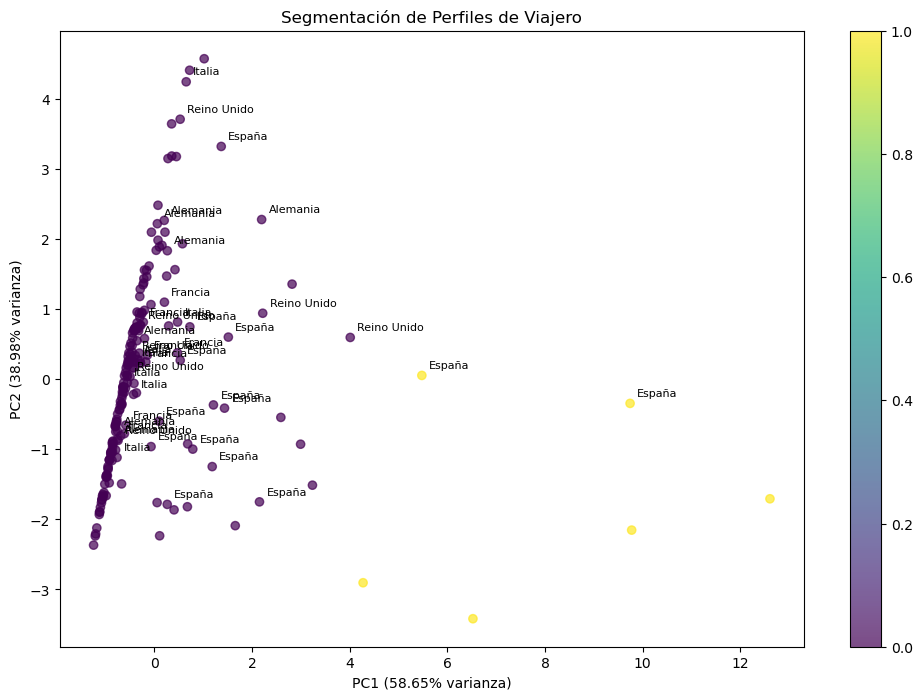

In [6]:
# Reducción dimensional para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_perfiles['pca1'] = X_pca[:, 0]
df_perfiles['pca2'] = X_pca[:, 1]

plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_perfiles['pca1'], df_perfiles['pca2'], 
                     c=df_perfiles['cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} varianza)')
plt.title('Segmentación de Perfiles de Viajero')

# Anotar algunos países importantes
paises_importantes = ['Alemania', 'Reino Unido', 'Francia', 'Italia', 'España']
for pais in paises_importantes:
    mask = df_perfiles['pais_residencia'].str.contains(pais, na=False)
    for idx in df_perfiles[mask].index:
        plt.annotate(pais, 
                    (df_perfiles.loc[idx, 'pca1'], df_perfiles.loc[idx, 'pca2']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.show()

In [7]:
# Analizar características de cada cluster
caracteristicas_clusters = df_perfiles.groupby('cluster').agg({
    'media_pernoctaciones': 'mean',
    'total_viajeros': 'mean', 
    'estancia_relativa': 'mean',
    'volumen_relativo': 'mean',
    'intensidad_visitas': 'mean',
    'pais_residencia': lambda x: x.value_counts().index[0],  # país más común
    'provincia': lambda x: x.value_counts().index[0],       # provincia más común
    'pais_residencia': 'count'  # número de países en cluster
}).round(2)

caracteristicas_clusters = caracteristicas_clusters.rename(columns={
    'pais_residencia': 'n_paises',
    'provincia': 'provincia_mas_comun'
})

print("Características de cada perfil:")
print(caracteristicas_clusters)

Características de cada perfil:
         media_pernoctaciones  total_viajeros  estancia_relativa  \
cluster                                                            
0                        4.67       247583.19               1.00   
1                        5.15      6102009.83               1.11   

         volumen_relativo  intensidad_visitas  n_paises provincia_mas_comun  
cluster                                                                      
0                    0.59             2947.42       196           Barcelona  
1                   14.55            72642.97         6      Islas Baleares  


In [8]:
# Asignar nombres descriptivos a clusters basados en sus características
perfil_nombres = {}

for cluster_id in df_perfiles['cluster'].unique():
    cluster_data = df_perfiles[df_perfiles['cluster'] == cluster_id]
    
    estancia_media = cluster_data['media_pernoctaciones'].mean()
    volumen_medio = cluster_data['total_viajeros'].mean()
    estancia_rel = cluster_data['estancia_relativa'].mean()
    
    # Determinar tipo de perfil
    if estancia_rel > 1.2 and volumen_medio > df_perfiles['total_viajeros'].median():
        nombre = "Turistas Premium (Larga Estancia + Alto Volumen)"
    elif estancia_rel > 1.1 and volumen_medio < df_perfiles['total_viajeros'].median():
        nombre = "Viajeros de Estancia Larga"
    elif estancia_rel < 0.9 and volumen_medio > df_perfiles['total_viajeros'].median():
        nombre = "Turismo Masivo (Corta Estancia)"
    elif volumen_medio < df_perfiles['total_viajeros'].quantile(0.3):
        nombre = "Nichos Especializados"
    else:
        nombre = "Turistas Regulares"
    
    perfil_nombres[cluster_id] = nombre

df_perfiles['perfil_nombre'] = df_perfiles['cluster'].map(perfil_nombres)

print("\nPerfiles identificados:")
for cluster_id, nombre in perfil_nombres.items():
    n_paises = len(df_perfiles[df_perfiles['cluster'] == cluster_id])
    print(f"Cluster {cluster_id}: {nombre} ({n_paises} países-provincias)")


Perfiles identificados:
Cluster 0: Turistas Regulares (196 países-provincias)
Cluster 1: Turistas Regulares (6 países-provincias)


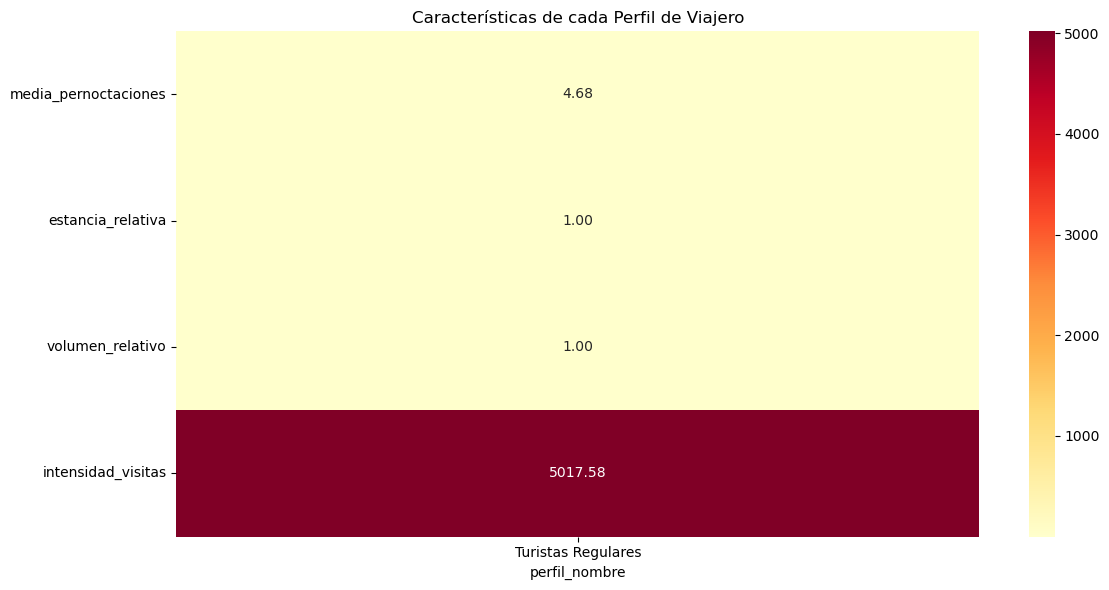

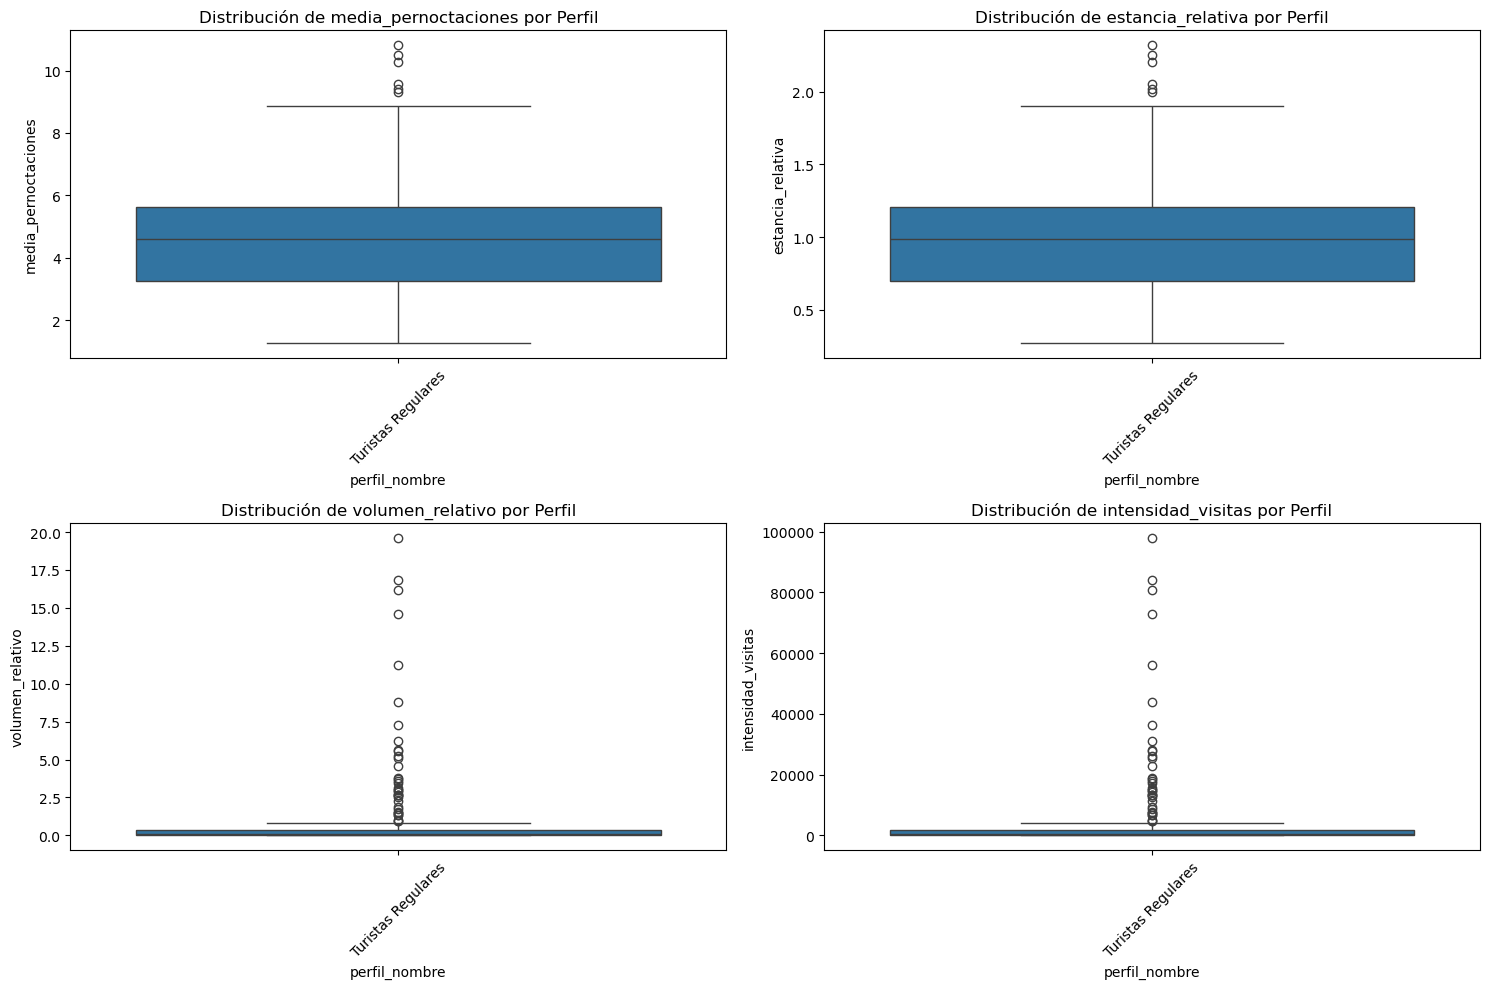

In [9]:
# Heatmap de características por perfil
caracteristicas_perfil = df_perfiles.groupby('perfil_nombre')[
    ['media_pernoctaciones', 'estancia_relativa', 'volumen_relativo', 'intensidad_visitas']
].mean()

plt.figure(figsize=(12, 6))
sns.heatmap(caracteristicas_perfil.T, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('Características de cada Perfil de Viajero')
plt.tight_layout()
plt.show()

# Boxplot por perfil
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

caracteristicas_viz = ['media_pernoctaciones', 'estancia_relativa', 'volumen_relativo', 'intensidad_visitas']

for i, caracteristica in enumerate(caracteristicas_viz):
    sns.boxplot(data=df_perfiles, x='perfil_nombre', y=caracteristica, ax=axes[i])
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].set_title(f'Distribución de {caracteristica} por Perfil')

plt.tight_layout()
plt.show()

In [10]:
# Países más representativos por perfil
print("TOP PAÍSES POR PERFIL:")
print("=" * 50)

for perfil in df_perfiles['perfil_nombre'].unique():
    print(f"\n{perfil}:")
    perfil_data = df_perfiles[df_perfiles['perfil_nombre'] == perfil]
    
    top_paises = perfil_data.groupby('pais_residencia').agg({
        'total_viajeros': 'sum',
        'media_pernoctaciones': 'mean',
        'provincia': 'count'
    }).nlargest(5, 'total_viajeros')
    
    print(top_paises.round(2))

TOP PAÍSES POR PERFIL:

Turistas Regulares:
                            total_viajeros  media_pernoctaciones  provincia
pais_residencia                                                            
Total                           26927244.0                  4.97          7
Extranjeros                     17624625.0                  2.70          7
Unión Europea (sin España)      13698992.0                  5.46          7
España                           9304365.0                  4.50          7
Reino Unido                      4694148.0                  5.90          7


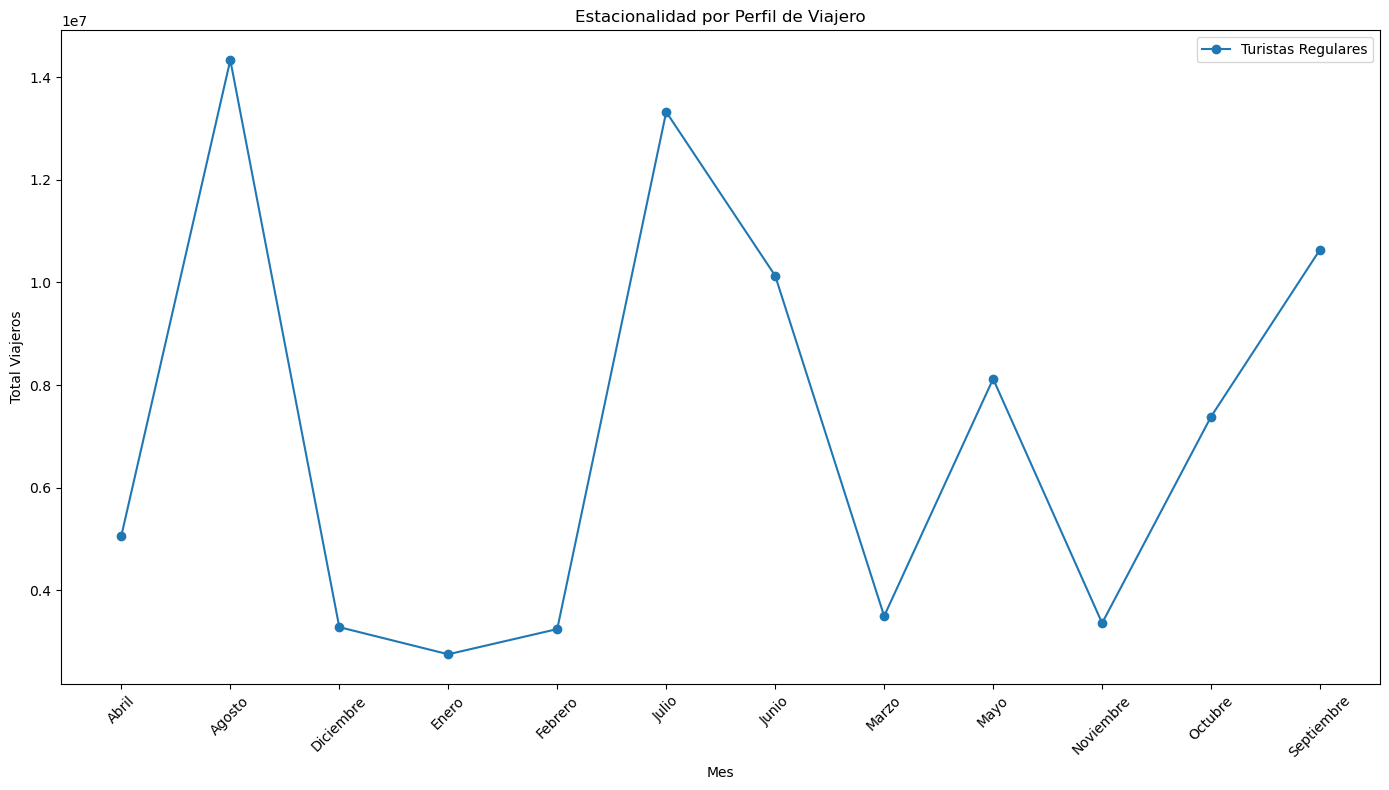

In [11]:
# Unir clusters con datos originales para análisis temporal
df_con_perfiles = pd.merge(
    df, 
    df_perfiles[['pais_residencia', 'provincia', 'cluster', 'perfil_nombre']],
    on=['pais_residencia', 'provincia'],
    how='left'
)

# Análisis estacional por perfil
estacionalidad_perfiles = df_con_perfiles.groupby(['perfil_nombre', 'mes']).agg({
    'total_viajeros': 'sum',
    'media_pernoctaciones': 'mean'
}).reset_index()

# Ordenar meses correctamente
meses_orden = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
              'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
estacionalidad_perfiles['mes'] = pd.Categorical(estacionalidad_perfiles['mes'], categories=meses_orden, ordered=True)

# Visualizar estacionalidad
plt.figure(figsize=(14, 8))
for perfil in estacionalidad_perfiles['perfil_nombre'].unique():
    perfil_data = estacionalidad_perfiles[estacionalidad_perfiles['perfil_nombre'] == perfil]
    plt.plot(perfil_data['mes'], perfil_data['total_viajeros'], label=perfil, marker='o')

plt.xlabel('Mes')
plt.ylabel('Total Viajeros')
plt.title('Estacionalidad por Perfil de Viajero')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
# Crear resumen ejecutivo
resumen_perfiles = df_perfiles.groupby('perfil_nombre').agg({
    'total_viajeros': 'sum',
    'media_pernoctaciones': 'mean',
    'pais_residencia': 'count',
    'pernoctaciones': 'sum'
}).round(2)

resumen_perfiles['%_total_viajeros'] = (resumen_perfiles['total_viajeros'] / resumen_perfiles['total_viajeros'].sum() * 100).round(1)
resumen_perfiles['ingreso_relativo'] = (resumen_perfiles['pernoctaciones'] / resumen_perfiles['total_viajeros']).round(2)

print("RESUMEN EJECUTIVO DE PERFILES:")
print("=" * 70)
print(resumen_perfiles.sort_values('%_total_viajeros', ascending=False))

RESUMEN EJECUTIVO DE PERFILES:
                    total_viajeros  media_pernoctaciones  pais_residencia  \
perfil_nombre                                                               
Turistas Regulares      85138364.0                  4.68              202   

                    pernoctaciones  %_total_viajeros  ingreso_relativo  
perfil_nombre                                                           
Turistas Regulares     400461730.0             100.0               4.7  


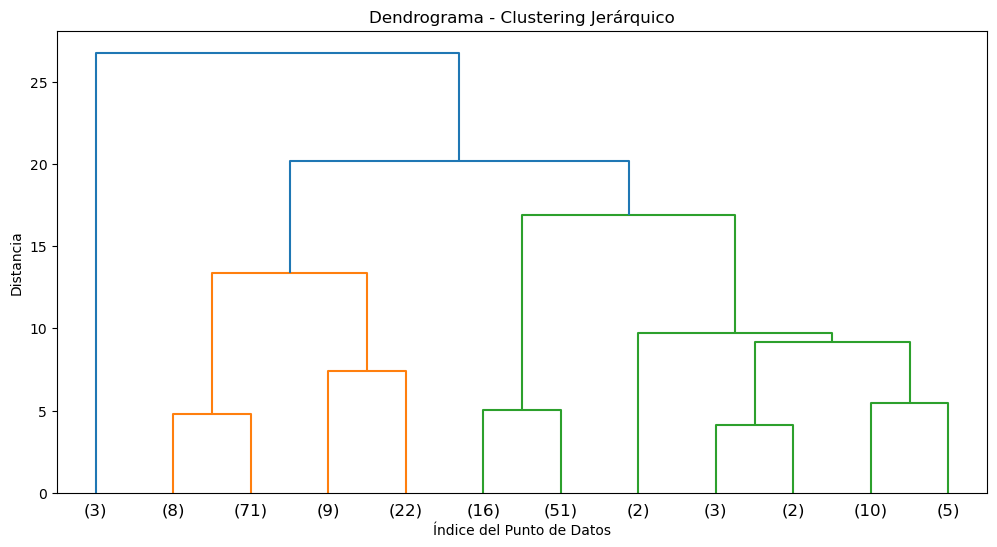

In [13]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# Clustering jerárquico
Z = linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 6))
dendrogram(Z, truncate_mode='lastp', p=12)
plt.title('Dendrograma - Clustering Jerárquico')
plt.xlabel('Índice del Punto de Datos')
plt.ylabel('Distancia')
plt.show()

# Test clustering pernoctaciones sin agrupados

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Cargar datos
df = pd.read_csv("../Data/datos_INE_consolidados_17112025.csv")

# Filtrar países específicos (excluir categorías agregadas)
paises_excluir = ['Total', 'Extranjeros', 'Unión Europea (sin España)', 
                  'Resto de la UE']

df_filtrado = df[~df['pais_residencia'].isin(paises_excluir)]

print(f"Países disponibles para análisis: {df_filtrado['pais_residencia'].unique()}")
print(f"Número de registros después de filtrar: {len(df_filtrado)}")

Países disponibles para análisis: ['España' 'Alemania' 'Austria' 'Bélgica' 'Dinamarca' 'Finlandia' 'Francia'
 'Grecia' 'Irlanda' 'Italia' 'Luxemburgo' 'Países Bajos' 'Polonia'
 'Portugal' 'Reino Unido' 'República Checa' 'Suecia' 'Noruega' 'Rusia'
 'Suiza' 'Estados Unidos' 'Resto de América' 'Países africanos'
 'Resto del mundo']
Número de registros después de filtrar: 14112


In [15]:
# Agrupar por país, provincia y mes para encontrar patrones
df_agrupado = df_filtrado.groupby(['pais_residencia', 'provincia', 'mes']).agg({
    'media_pernoctaciones': 'mean',
    'total_viajeros': 'sum',
    'pernoctaciones': 'sum'
}).reset_index()

# Calcular el mes de visita más probable para cada país-provincia
def encontrar_mes_mas_probable(grupo):
    idx_max = grupo['total_viajeros'].idxmax()
    return pd.Series({
        'mes_mas_probable': grupo.loc[idx_max, 'mes'],
        'total_viajeros_mes_pico': grupo.loc[idx_max, 'total_viajeros'],
        'media_pernoctaciones_mes_pico': grupo.loc[idx_max, 'media_pernoctaciones']
    })

meses_probables = df_agrupado.groupby(['pais_residencia', 'provincia']).apply(
    encontrar_mes_mas_probable
).reset_index()

# Calcular estadísticas generales por país-provincia
estadisticas_generales = df_filtrado.groupby(['pais_residencia', 'provincia']).agg({
    'media_pernoctaciones': ['mean', 'std', 'min', 'max'],
    'total_viajeros': 'sum',
    'pernoctaciones': 'sum'
}).round(2)

estadisticas_generales.columns = ['_'.join(col).strip() for col in estadisticas_generales.columns.values]
estadisticas_generales = estadisticas_generales.reset_index()

# Combinar toda la información
df_perfiles_detallados = pd.merge(
    estadisticas_generales,
    meses_probables,
    on=['pais_residencia', 'provincia']
)

# Ordenar por total de viajeros
df_perfiles_detallados = df_perfiles_detallados.sort_values('total_viajeros_sum', ascending=False)

print("Perfiles de viajero detallados:")
print(df_perfiles_detallados.head(10))

Perfiles de viajero detallados:
    pais_residencia       provincia  media_pernoctaciones_mean  \
121     Reino Unido  Islas Baleares                       6.69   
32           España          Málaga                       3.22   
123     Reino Unido          Málaga                       6.58   
31           España          Madrid                       3.53   
30           España  Islas Baleares                       4.64   
2          Alemania  Islas Baleares                       8.25   
34           España        Valencia                       4.60   
29           España          Girona                       3.68   
33           España         Sevilla                       2.54   
28           España       Barcelona                       9.32   

     media_pernoctaciones_std  media_pernoctaciones_min  \
121                      2.08                       0.0   
32                       0.94                       0.0   
123                      2.26                       0.0   
31   

In [16]:
# Crear características para clasificación de perfiles
df_perfiles_detallados['estancia_categoria'] = pd.cut(
    df_perfiles_detallados['media_pernoctaciones_mean'],
    bins=[0, 4, 7, 15, 100],
    labels=['Estancia Corta', 'Estancia Media', 'Estancia Larga', 'Estancia Muy Larga']
)

df_perfiles_detallados['volumen_categoria'] = pd.cut(
    df_perfiles_detallados['total_viajeros_sum'],
    bins=[0, 1000, 10000, 100000, float('inf')],
    labels=['Muy Bajo', 'Bajo', 'Medio', 'Alto']
)

# Clasificar estacionalidad basada en el mes más probable
def clasificar_estacionalidad(mes):
    if mes in ['Junio', 'Julio', 'Agosto']:
        return 'Alta Temporada (Verano)'
    elif mes in ['Abril', 'Mayo', 'Septiembre']:
        return 'Temporada Media'
    elif mes in ['Enero', 'Febrero', 'Marzo', 'Octubre', 'Noviembre']:
        return 'Baja Temporada'
    else:  # Diciembre
        return 'Temporada Navideña'

df_perfiles_detallados['estacionalidad'] = df_perfiles_detallados['mes_mas_probable'].apply(clasificar_estacionalidad)

# Crear perfil consolidado
df_perfiles_detallados['perfil_viajero'] = (
    df_perfiles_detallados['estancia_categoria'].astype(str) + " - " +
    df_perfiles_detallados['volumen_categoria'].astype(str) + " - " +
    df_perfiles_detallados['estacionalidad']
)

print("\nDistribución de perfiles identificados:")
print(df_perfiles_detallados['perfil_viajero'].value_counts())


Distribución de perfiles identificados:
perfil_viajero
Estancia Media - Medio - Alta Temporada (Verano)    33
Estancia Media - Alto - Alta Temporada (Verano)     22
Estancia Corta - Bajo - Alta Temporada (Verano)     19
Estancia Corta - Medio - Baja Temporada             12
Estancia Larga - Alto - Alta Temporada (Verano)      9
Estancia Corta - Bajo - Baja Temporada               9
Estancia Media - Medio - Temporada Media             9
Estancia Media - Medio - Baja Temporada              6
Estancia Media - Bajo - Alta Temporada (Verano)      6
Estancia Corta - Medio - Temporada Media             6
Estancia Corta - Medio - Alta Temporada (Verano)     5
Estancia Corta - Alto - Alta Temporada (Verano)      5
Estancia Corta - Bajo - Temporada Media              4
Estancia Larga - Alto - Baja Temporada               4
Estancia Larga - Medio - Alta Temporada (Verano)     3
Estancia Corta - Alto - Baja Temporada               3
Estancia Media - Alto - Baja Temporada               3
Estancia 

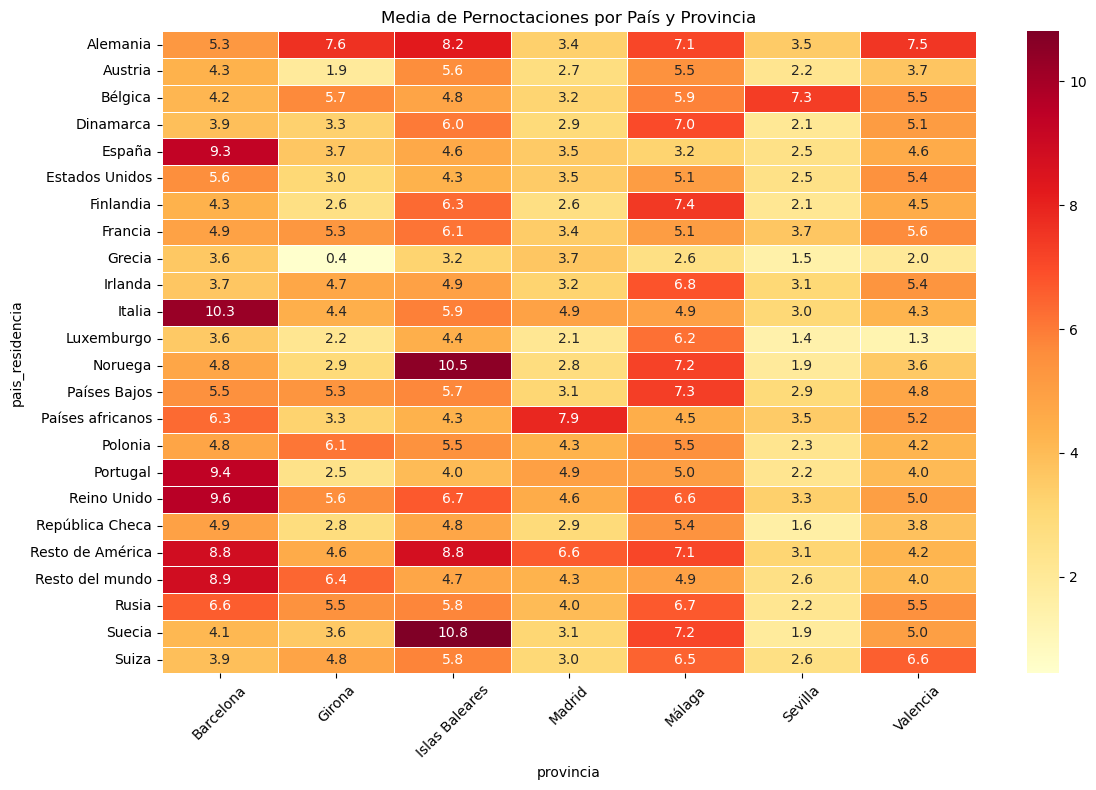

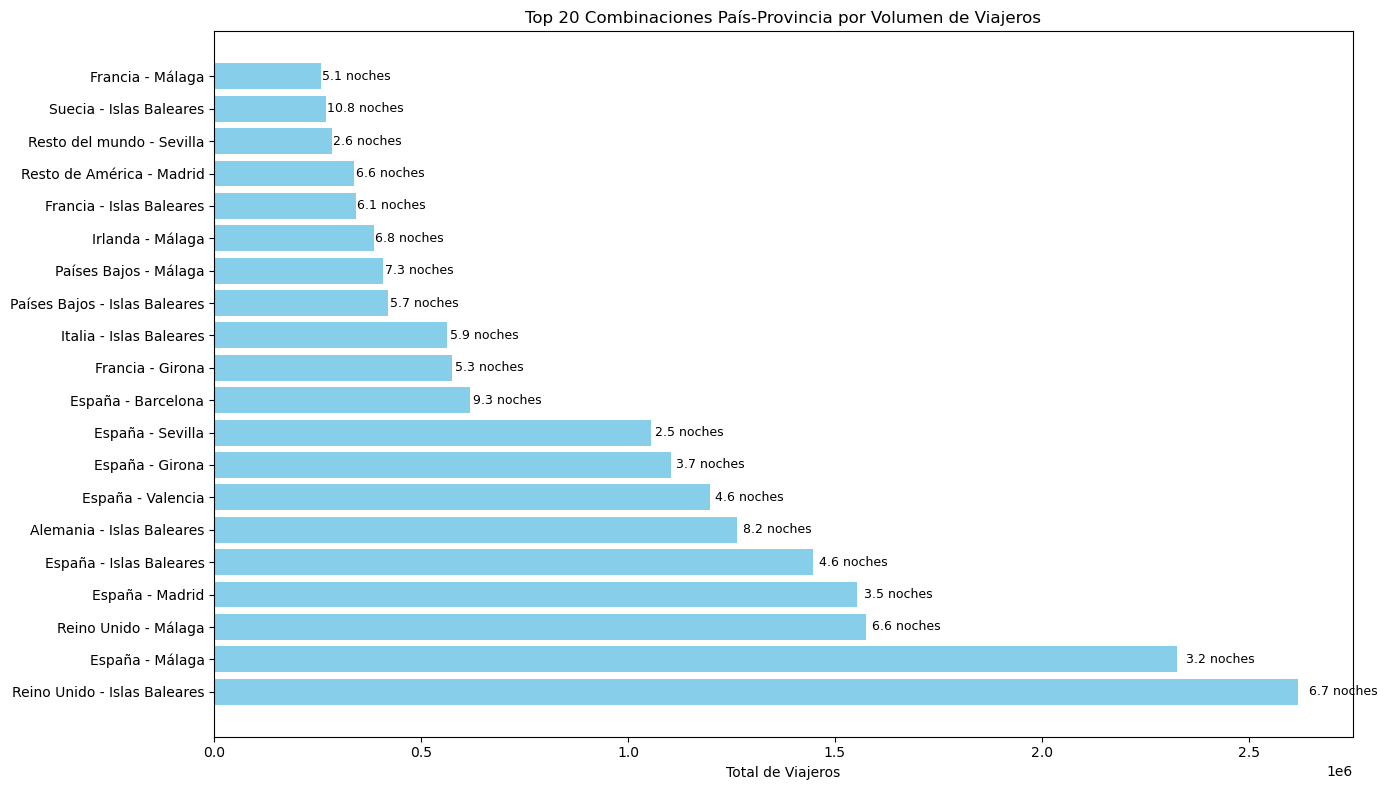

In [17]:
# Heatmap de países vs provincias (media de pernoctaciones)
pivot_media = df_perfiles_detallados.pivot_table(
    values='media_pernoctaciones_mean',
    index='pais_residencia',
    columns='provincia',
    aggfunc='mean'
)

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_media, annot=True, cmap='YlOrRd', fmt='.1f', linewidths=0.5)
plt.title('Media de Pernoctaciones por País y Provincia')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Gráfico de barras: top combinaciones país-provincia
top_20 = df_perfiles_detallados.head(20)

plt.figure(figsize=(14, 8))
bars = plt.barh(
    range(len(top_20)),
    top_20['total_viajeros_sum'],
    color='skyblue'
)

plt.yticks(range(len(top_20)), 
          [f"{pais} - {prov}" for pais, prov in zip(top_20['pais_residencia'], top_20['provincia'])])
plt.xlabel('Total de Viajeros')
plt.title('Top 20 Combinaciones País-Provincia por Volumen de Viajeros')

# Añadir etiquetas con media de pernoctaciones
for i, bar in enumerate(bars):
    media = top_20.iloc[i]['media_pernoctaciones_mean']
    plt.text(bar.get_width() + bar.get_width()*0.01, bar.get_y() + bar.get_height()/2,
             f'{media:.1f} noches', va='center', fontsize=9)

plt.tight_layout()
plt.show()

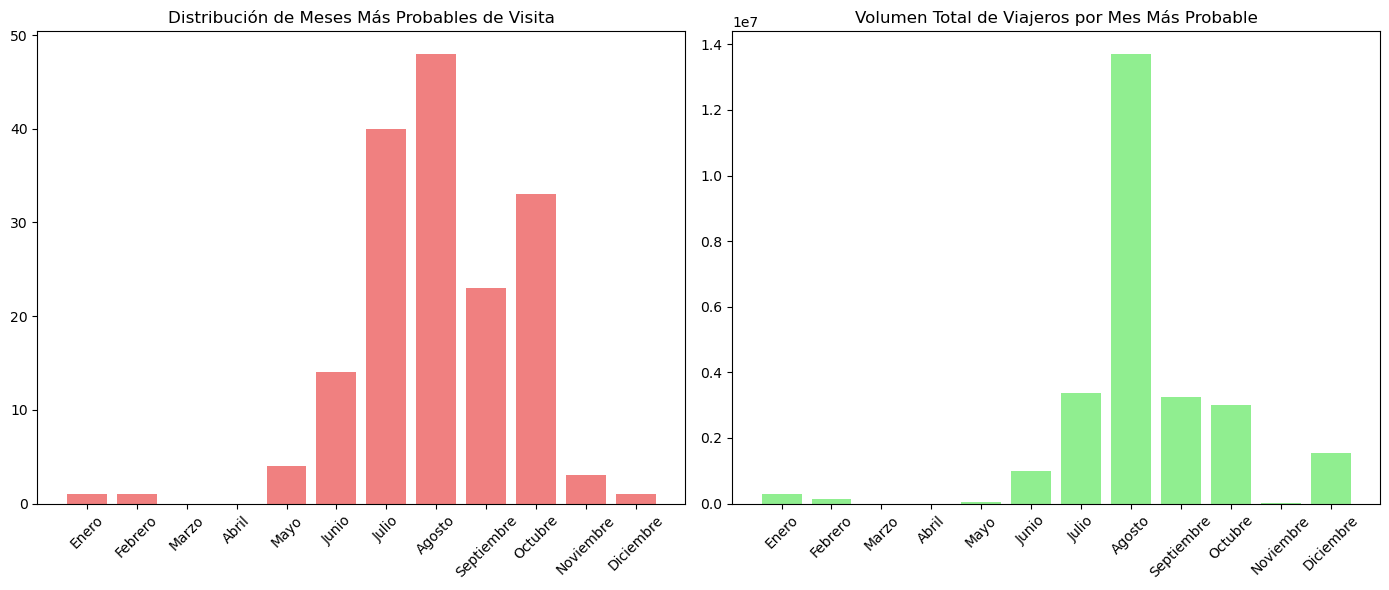

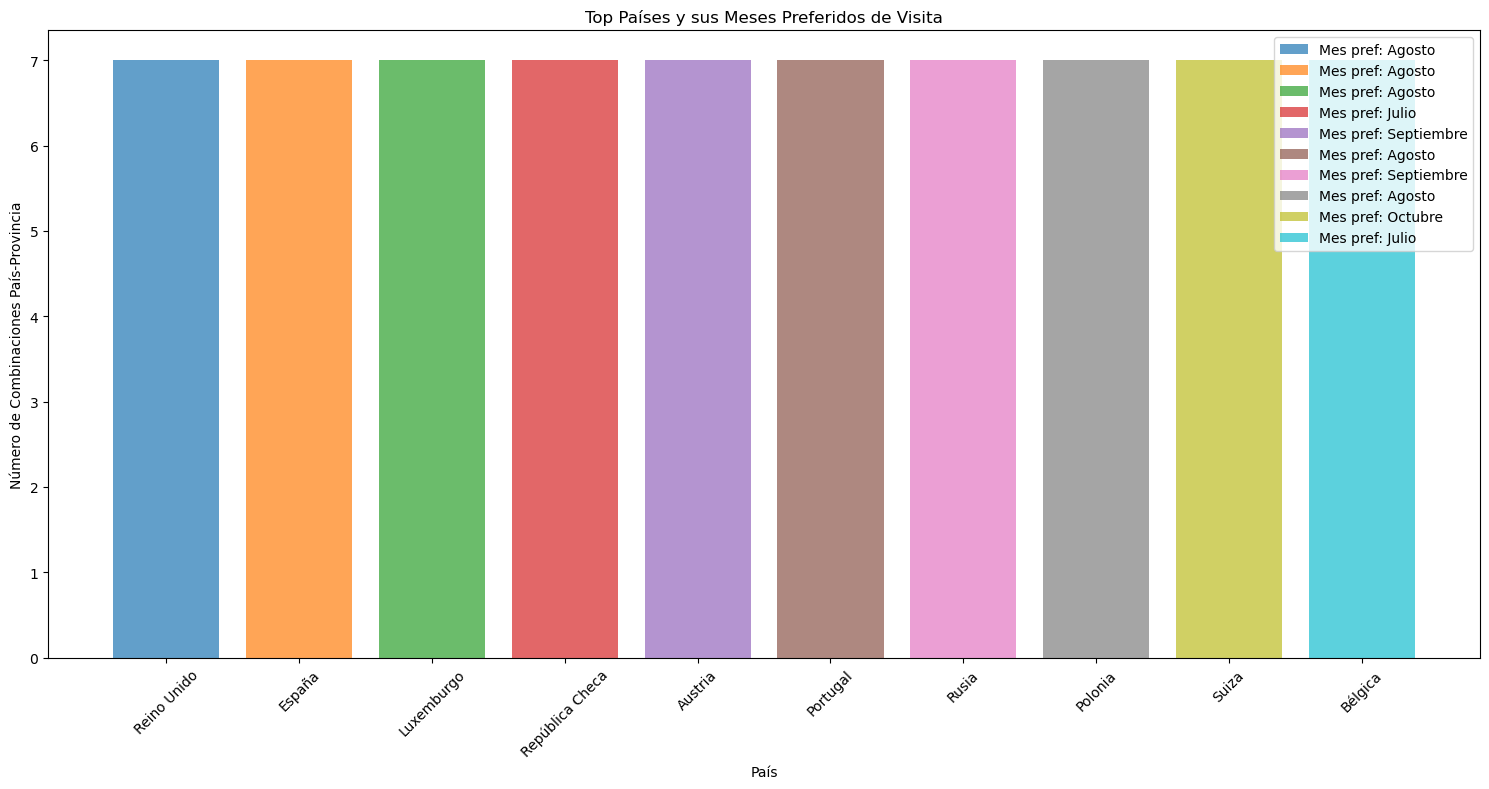

In [18]:
# Análisis de distribución de meses más probables
mes_orden = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
            'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']

plt.figure(figsize=(14, 6))

# Gráfico 1: Distribución general de meses más probables
plt.subplot(1, 2, 1)
mes_counts = df_perfiles_detallados['mes_mas_probable'].value_counts()
mes_counts = mes_counts.reindex(mes_orden)
plt.bar(mes_counts.index, mes_counts.values, color='lightcoral')
plt.title('Distribución de Meses Más Probables de Visita')
plt.xticks(rotation=45)

# Gráfico 2: Meses más probables por volumen de viajeros
plt.subplot(1, 2, 2)
mes_volumen = df_perfiles_detallados.groupby('mes_mas_probable')['total_viajeros_sum'].sum()
mes_volumen = mes_volumen.reindex(mes_orden)
plt.bar(mes_volumen.index, mes_volumen.values, color='lightgreen')
plt.title('Volumen Total de Viajeros por Mes Más Probable')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Análisis por país: mes preferido
paises_top = df_perfiles_detallados['pais_residencia'].value_counts().head(10).index

plt.figure(figsize=(15, 8))
for i, pais in enumerate(paises_top):
    pais_data = df_perfiles_detallados[df_perfiles_detallados['pais_residencia'] == pais]
    mes_preferido = pais_data['mes_mas_probable'].value_counts().index[0]
    count = len(pais_data)
    
    plt.bar(pais, count, label=f'Mes pref: {mes_preferido}', alpha=0.7)

plt.title('Top Países y sus Meses Preferidos de Visita')
plt.xlabel('País')
plt.ylabel('Número de Combinaciones País-Provincia')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
def buscar_perfil_viajero(pais=None, provincia=None, estancia_min=None, 
                         estancia_max=None, mes_preferido=None):
    """
    Buscar perfiles de viajero según criterios específicos
    """
    resultados = df_perfiles_detallados.copy()
    
    if pais:
        resultados = resultados[resultados['pais_residencia'] == pais]
    if provincia:
        resultados = resultados[resultados['provincia'] == provincia]
    if estancia_min is not None:
        resultados = resultados[resultados['media_pernoctaciones_mean'] >= estancia_min]
    if estancia_max is not None:
        resultados = resultados[resultados['media_pernoctaciones_mean'] <= estancia_max]
    if mes_preferido:
        resultados = resultados[resultados['mes_mas_probable'] == mes_preferido]
    
    return resultados.sort_values('total_viajeros_sum', ascending=False)

# Ejemplos de búsqueda
print("=== EJEMPLO 1: Viajeros alemanes ===")
alemanes = buscar_perfil_viajero(pais='Alemania')
print(alemanes[['pais_residencia', 'provincia', 'media_pernoctaciones_mean', 
                'mes_mas_probable', 'total_viajeros_sum']].head())

print("\n=== EJEMPLO 2: Viajeros con estancia larga (>7 noches) ===")
estancia_larga = buscar_perfil_viajero(estancia_min=7)
print(estancia_larga[['pais_residencia', 'provincia', 'media_pernoctaciones_mean', 
                      'mes_mas_probable', 'total_viajeros_sum']].head())

print("\n=== EJEMPLO 3: Viajeros en Agosto ===")
agosto = buscar_perfil_viajero(mes_preferido='Agosto')
print(agosto[['pais_residencia', 'provincia', 'media_pernoctaciones_mean', 
              'mes_mas_probable', 'total_viajeros_sum']].head())

=== EJEMPLO 1: Viajeros alemanes ===
  pais_residencia       provincia  media_pernoctaciones_mean mes_mas_probable  \
2        Alemania  Islas Baleares                       8.25            Julio   
4        Alemania          Málaga                       7.09          Octubre   
1        Alemania          Girona                       7.62           Agosto   
0        Alemania       Barcelona                       5.26          Octubre   
6        Alemania        Valencia                       7.52          Octubre   

   total_viajeros_sum  
2           1264365.0  
4            247064.0  
1            128596.0  
0             88162.0  
6             70752.0  

=== EJEMPLO 2: Viajeros con estancia larga (>7 noches) ===
    pais_residencia       provincia  media_pernoctaciones_mean  \
2          Alemania  Islas Baleares                       8.25   
28           España       Barcelona                       9.32   
95     Países Bajos          Málaga                       7.31   
156     

In [20]:
# Identificar perfiles típicos automáticamente
def identificar_perfiles_tipicos():
    perfiles_comunes = []
    
    # Perfil 1: Turista de verano alemán en Baleares
    aleman_baleares = df_perfiles_detallados[
        (df_perfiles_detallados['pais_residencia'] == 'Alemania') &
        (df_perfiles_detallados['provincia'] == 'Islas Baleares')
    ]
    
    # Perfil 2: Británico en Málaga
    britanico_malaga = df_perfiles_detallados[
        (df_perfiles_detallados['pais_residencia'] == 'Reino Unido') &
        (df_perfiles_detallados['provincia'] == 'Málaga')
    ]
    
    # Perfil 3: Francés en Girona
    frances_girona = df_perfiles_detallados[
        (df_perfiles_detallados['pais_residencia'] == 'Francia') &
        (df_perfiles_detallados['provincia'] == 'Girona')
    ]
    
    return {
        'Turista Alemán en Baleares': aleman_baleares,
        'Turista Británico en Málaga': britanico_malaga,
        'Turista Francés en Girona': frances_girona
    }

perfiles_tipicos = identificar_perfiles_tipicos()

for nombre, perfil in perfiles_tipicos.items():
    if not perfil.empty:
        print(f"\n=== {nombre} ===")
        print(f"Media de pernoctaciones: {perfil['media_pernoctaciones_mean'].values[0]:.1f}")
        print(f"Mes más probable: {perfil['mes_mas_probable'].values[0]}")
        print(f"Total viajeros: {perfil['total_viajeros_sum'].values[0]:,.0f}")
        print(f"Estacionalidad: {perfil['estacionalidad'].values[0]}")


=== Turista Alemán en Baleares ===
Media de pernoctaciones: 8.2
Mes más probable: Julio
Total viajeros: 1,264,365
Estacionalidad: Alta Temporada (Verano)

=== Turista Británico en Málaga ===
Media de pernoctaciones: 6.6
Mes más probable: Septiembre
Total viajeros: 1,573,932
Estacionalidad: Temporada Media

=== Turista Francés en Girona ===
Media de pernoctaciones: 5.3
Mes más probable: Agosto
Total viajeros: 575,305
Estacionalidad: Alta Temporada (Verano)


In [21]:
# Crear resumen ejecutivo
resumen_final = df_perfiles_detallados[[
    'pais_residencia', 'provincia', 'media_pernoctaciones_mean',
    'mes_mas_probable', 'total_viajeros_sum', 'estacionalidad', 'perfil_viajero'
]]

# Exportar a CSV
#resumen_final.to_csv('perfiles_viajeros_detallados.csv', index=False, encoding='utf-8-sig')

print("Resumen de perfiles exportado a 'perfiles_viajeros_detallados.csv'")

# Top perfiles por diferentes criterios
print("\n" + "="*50)
print("TOP PERFILES POR DIFERENTES CRITERIOS")
print("="*50)

print("\n🔹 TOP 5 por Volumen de Viajeros:")
print(resumen_final.nlargest(5, 'total_viajeros_sum')[['pais_residencia', 'provincia', 'total_viajeros_sum']])

print("\n🔹 TOP 5 por Estancia Más Larga:")
print(resumen_final.nlargest(5, 'media_pernoctaciones_mean')[['pais_residencia', 'provincia', 'media_pernoctaciones_mean']])

print("\n🔹 TOP Países por Presencia en Provincias:")
presencia_paises = resumen_final['pais_residencia'].value_counts()
print(presencia_paises.head(10))

Resumen de perfiles exportado a 'perfiles_viajeros_detallados.csv'

TOP PERFILES POR DIFERENTES CRITERIOS

🔹 TOP 5 por Volumen de Viajeros:
    pais_residencia       provincia  total_viajeros_sum
121     Reino Unido  Islas Baleares           2620244.0
32           España          Málaga           2326158.0
123     Reino Unido          Málaga           1573932.0
31           España          Madrid           1554092.0
30           España  Islas Baleares           1447253.0

🔹 TOP 5 por Estancia Más Larga:
    pais_residencia       provincia  media_pernoctaciones_mean
156          Suecia  Islas Baleares                      10.81
86          Noruega  Islas Baleares                      10.51
70           Italia       Barcelona                      10.28
119     Reino Unido       Barcelona                       9.56
112        Portugal       Barcelona                       9.42

🔹 TOP Países por Presencia en Provincias:
pais_residencia
Reino Unido        7
España             7
Luxemburgo  

In [22]:
# Función para generar reporte personalizado por país
def generar_reporte_pais(pais):
    datos_pais = df_perfiles_detallados[df_perfiles_detallados['pais_residencia'] == pais]
    
    if datos_pais.empty:
        return f"No hay datos para el país: {pais}"
    
    print(f"\n📊 REPORTE COMPLETO PARA: {pais}")
    print("="*60)
    
    print(f"🔸 Número de provincias visitadas: {len(datos_pais)}")
    print(f"🔸 Estancia media general: {datos_pais['media_pernoctaciones_mean'].mean():.1f} noches")
    print(f"🔸 Mes preferido más común: {datos_pais['mes_mas_probable'].mode().values[0]}")
    print(f"🔸 Volumen total de viajeros: {datos_pais['total_viajeros_sum'].sum():,.0f}")
    
    print(f"\n🏆 TOP 3 Provincias Preferidas:")
    top_provincias = datos_pais.nlargest(3, 'total_viajeros_sum')
    for i, (_, row) in enumerate(top_provincias.iterrows(), 1):
        print(f"   {i}. {row['provincia']}: {row['total_viajeros_sum']:,.0f} viajeros, "
              f"{row['media_pernoctaciones_mean']:.1f} noches, mes: {row['mes_mas_probable']}")
    
    return datos_pais

# Ejemplo de uso
reporte_alemania = generar_reporte_pais('Alemania')
reporte_reino_unido = generar_reporte_pais('Reino Unido')


📊 REPORTE COMPLETO PARA: Alemania
🔸 Número de provincias visitadas: 7
🔸 Estancia media general: 6.1 noches
🔸 Mes preferido más común: Octubre
🔸 Volumen total de viajeros: 1,919,118

🏆 TOP 3 Provincias Preferidas:
   1. Islas Baleares: 1,264,365 viajeros, 8.2 noches, mes: Julio
   2. Málaga: 247,064 viajeros, 7.1 noches, mes: Octubre
   3. Girona: 128,596 viajeros, 7.6 noches, mes: Agosto

📊 REPORTE COMPLETO PARA: Reino Unido
🔸 Número de provincias visitadas: 7
🔸 Estancia media general: 5.9 noches
🔸 Mes preferido más común: Agosto
🔸 Volumen total de viajeros: 4,694,148

🏆 TOP 3 Provincias Preferidas:
   1. Islas Baleares: 2,620,244 viajeros, 6.7 noches, mes: Agosto
   2. Málaga: 1,573,932 viajeros, 6.6 noches, mes: Septiembre
   3. Barcelona: 132,279 viajeros, 9.6 noches, mes: Julio


# Test con algoritmos no supervisados

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')

# Cargar y preparar datos
df = pd.read_csv("../Data/datos_INE_consolidados_17112025.csv")

# Filtrar países específicos (excluir categorías agregadas)
paises_excluir = ['Total', 'Extranjeros', 'Unión Europea (sin España)', 
                  'Resto de la UE']

df_filtrado = df[~df['pais_residencia'].isin(paises_excluir)]

print(f"Países disponibles para clustering: {len(df_filtrado['pais_residencia'].unique())}")

Países disponibles para clustering: 25


In [24]:
# Crear dataset para clustering - agrupar por país y provincia
df_cluster = df_filtrado.groupby(['pais_residencia', 'provincia']).agg({
    'media_pernoctaciones': ['mean', 'std', 'min', 'max'],
    'total_viajeros': ['sum', 'mean'],
    'pernoctaciones': 'sum',
    'mes': 'count'
}).round(3)

# Aplanar columnas multi-index
df_cluster.columns = ['_'.join(col).strip() for col in df_cluster.columns.values]
df_cluster = df_cluster.reset_index()

# Calcular características adicionales para clustering
df_cluster['estancia_relativa'] = df_cluster['media_pernoctaciones_mean'] / df_cluster['media_pernoctaciones_mean'].mean()
df_cluster['volumen_relativo'] = df_cluster['total_viajeros_sum'] / df_cluster['total_viajeros_sum'].mean()
df_cluster['variabilidad_estancia'] = df_cluster['media_pernoctaciones_std'] / df_cluster['media_pernoctaciones_mean']
df_cluster['intensidad_visitas'] = df_cluster['total_viajeros_sum'] / df_cluster['mes_count']

# Encontrar mes más probable para cada combinación
def get_mes_mas_probable(group):
    return df_filtrado[
        (df_filtrado['pais_residencia'] == group['pais_residencia']) & 
        (df_filtrado['provincia'] == group['provincia'])
    ].groupby('mes')['total_viajeros'].sum().idxmax()

df_cluster['mes_mas_probable'] = df_cluster.apply(get_mes_mas_probable, axis=1)

# Codificar mes como variable numérica cíclica
meses_orden = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
              'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
mes_a_num = {mes: i for i, mes in enumerate(meses_orden)}
df_cluster['mes_num'] = df_cluster['mes_mas_probable'].map(mes_a_num)

# Variables cíclicas para mes (para capturar patrones estacionales)
df_cluster['mes_sin'] = np.sin(2 * np.pi * df_cluster['mes_num'] / 12)
df_cluster['mes_cos'] = np.cos(2 * np.pi * df_cluster['mes_num'] / 12)

print(f"Dataset para clustering: {df_cluster.shape}")
print(df_cluster.head())

Dataset para clustering: (175, 18)
  pais_residencia       provincia  media_pernoctaciones_mean  \
0        Alemania       Barcelona                      5.264   
1        Alemania          Girona                      7.618   
2        Alemania  Islas Baleares                      8.254   
3        Alemania          Madrid                      3.350   
4        Alemania          Málaga                      7.091   

   media_pernoctaciones_std  media_pernoctaciones_min  \
0                     3.562                       0.0   
1                     3.457                       0.0   
2                     3.273                       0.0   
3                     1.126                       0.0   
4                     2.479                       0.0   

   media_pernoctaciones_max  total_viajeros_sum  total_viajeros_mean  \
0                     33.75             88162.0             1049.548   
1                     17.23            128596.0             1530.905   
2                    

In [25]:
# Seleccionar características para clustering
features = [
    'media_pernoctaciones_mean',  # Estancia promedio
    'estancia_relativa',          # Estancia relativa al promedio
    'volumen_relativo',           # Volumen relativo de viajeros
    'variabilidad_estancia',      # Consistencia en la estancia
    'intensidad_visitas',         # Intensidad de visitas
    'mes_sin', 'mes_cos'          # Estacionalidad
]

X = df_cluster[features]

# Escalar características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Características escaladas para clustering:")
print(pd.DataFrame(X_scaled, columns=features).describe())

Características escaladas para clustering:
       media_pernoctaciones_mean  estancia_relativa  volumen_relativo  \
count               1.750000e+02       1.750000e+02      1.750000e+02   
mean               -4.060244e-17      -4.060244e-17      2.030122e-17   
std                 1.002869e+00       1.002869e+00      1.002869e+00   
min                -2.219714e+00      -2.219714e+00     -4.132203e-01   
25%                -7.520848e-01      -7.520848e-01     -3.832816e-01   
50%                -4.430510e-02      -4.430510e-02     -3.196055e-01   
75%                 4.667092e-01       4.667092e-01     -1.056145e-01   
max                 3.205987e+00       3.205987e+00      6.740802e+00   

       variabilidad_estancia  intensidad_visitas       mes_sin       mes_cos  
count           1.750000e+02        1.750000e+02  1.750000e+02  1.750000e+02  
mean            2.791418e-16        1.319579e-16 -2.030122e-17  1.167320e-16  
std             1.002869e+00        1.002869e+00  1.002869e+00

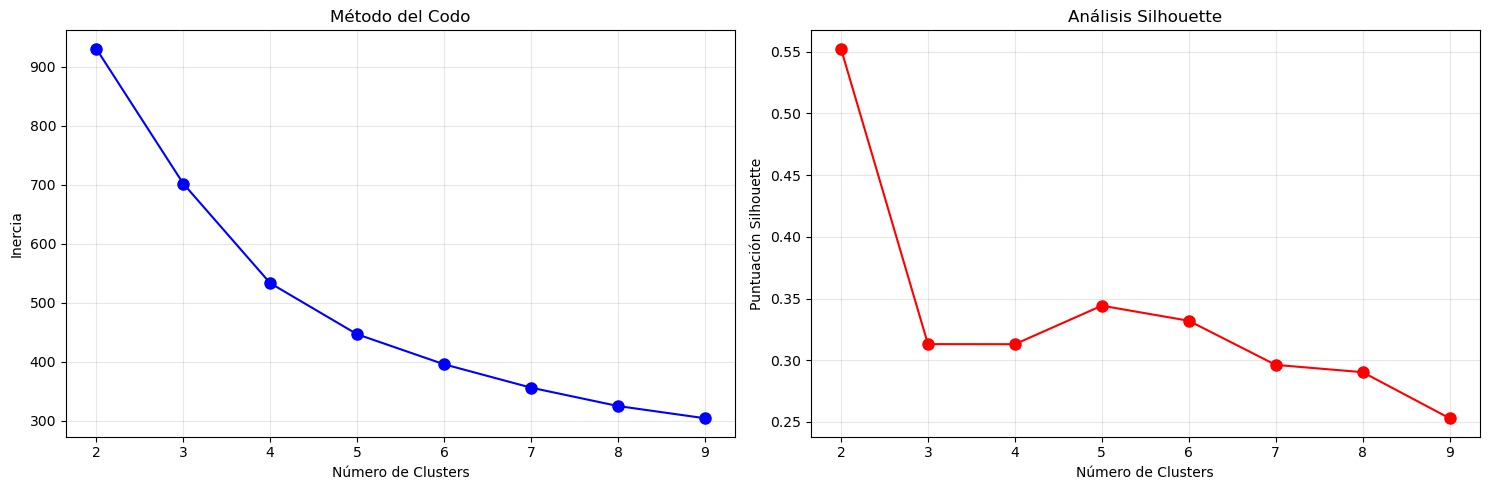

Número óptimo de clusters: 2 (Silhouette: 0.552)


In [26]:
# Método del codo y análisis de silhouette
inertia = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, cluster_labels))

# Visualizar métodos de selección
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Método del codo
ax1.plot(k_range, inertia, 'bo-', markersize=8)
ax1.set_xlabel('Número de Clusters')
ax1.set_ylabel('Inercia')
ax1.set_title('Método del Codo')
ax1.grid(True, alpha=0.3)

# Análisis de silhouette
ax2.plot(k_range, silhouette_scores, 'ro-', markersize=8)
ax2.set_xlabel('Número de Clusters')
ax2.set_ylabel('Puntuación Silhouette')
ax2.set_title('Análisis Silhouette')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Seleccionar k óptimo
optimal_k = k_range[np.argmax(silhouette_scores)]
print(f"Número óptimo de clusters: {optimal_k} (Silhouette: {silhouette_scores[optimal_k-2]:.3f})")

In [27]:
# Aplicar K-Means con k óptimo
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_cluster['cluster'] = kmeans.fit_predict(X_scaled)

# Calcular silhouette score final
silhouette_avg = silhouette_score(X_scaled, df_cluster['cluster'])
print(f"Silhouette Score final: {silhouette_avg:.3f}")

# Añadir coordenadas de los centroides
centroids = kmeans.cluster_centers_
df_cluster['distancia_centroide'] = kmeans.transform(X_scaled).min(axis=1)

Silhouette Score final: 0.552


Varianza explicada por PCA: 62.43%


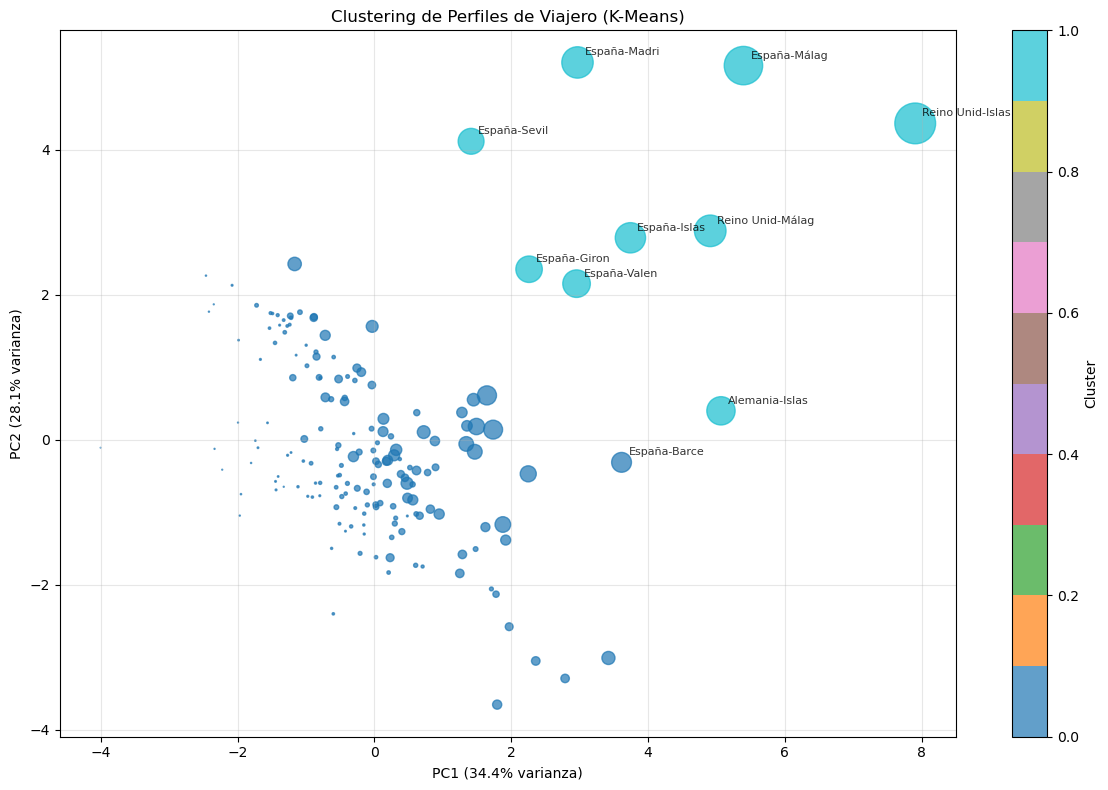

In [28]:
# Reducción dimensional con PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

df_cluster['pca1'] = X_pca[:, 0]
df_cluster['pca2'] = X_pca[:, 1]

print(f"Varianza explicada por PCA: {pca.explained_variance_ratio_.sum():.2%}")

# Visualización de clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(df_cluster['pca1'], df_cluster['pca2'], 
                     c=df_cluster['cluster'], cmap='tab10', 
                     s=df_cluster['volumen_relativo']*50, alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} varianza)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} varianza)')
plt.title('Clustering de Perfiles de Viajero (K-Means)')

# Anotar algunos puntos importantes
for i, row in df_cluster.nlargest(10, 'total_viajeros_sum').iterrows():
    plt.annotate(f"{row['pais_residencia'][:10]}-{row['provincia'][:5]}", 
                (row['pca1'], row['pca2']), xytext=(5, 5), 
                textcoords='offset points', fontsize=8, alpha=0.8)

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [29]:
# Analizar características de cada cluster
caracteristicas_clusters = df_cluster.groupby('cluster').agg({
    'media_pernoctaciones_mean': ['mean', 'std'],
    'volumen_relativo': 'mean',
    'estancia_relativa': 'mean',
    'variabilidad_estancia': 'mean',
    'intensidad_visitas': 'mean',
    'mes_mas_probable': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 'N/A',
    'pais_residencia': 'count',
    'total_viajeros_sum': 'sum'
}).round(3)

caracteristicas_clusters.columns = ['_'.join(col).strip() for col in caracteristicas_clusters.columns.values]
caracteristicas_clusters = caracteristicas_clusters.rename(columns={
    'pais_residencia_count': 'n_segmentos',
    'total_viajeros_sum_sum': 'total_viajeros_cluster'
})

print("CARACTERÍSTICAS DE CADA CLUSTER:")
print("="*60)
print(caracteristicas_clusters)

CARACTERÍSTICAS DE CADA CLUSTER:
         media_pernoctaciones_mean_mean  media_pernoctaciones_mean_std  \
cluster                                                                  
0                                 4.677                          1.922   
1                                 4.860                          1.910   

         volumen_relativo_mean  estancia_relativa_mean  \
cluster                                                  
0                        0.493                   0.998   
1                       10.347                   1.037   

         variabilidad_estancia_mean  intensidad_visitas_mean  \
cluster                                                        
0                             0.802                  891.867   
1                             0.346                18709.163   

        mes_mas_probable_<lambda>  n_segmentos  total_viajeros_cluster  
cluster                                                                 
0                          Agosto 

In [30]:
# Asignar nombres descriptivos basados en características
def asignar_nombre_cluster(cluster_data):
    estancia_media = cluster_data['media_pernoctaciones_mean_mean']
    volumen_medio = cluster_data['volumen_relativo_mean']
    variabilidad = cluster_data['variabilidad_estancia_mean']
    mes_comun = cluster_data['mes_mas_probable_<lambda>']
    
    # Determinar perfil basado en características
    if estancia_media > df_cluster['media_pernoctaciones_mean'].quantile(0.75):
        if volumen_medio > df_cluster['volumen_relativo'].quantile(0.75):
            nombre = "Turistas Premium (Larga Estancia + Alto Volumen)"
        else:
            nombre = "Viajeros de Estancia Larga (Bajo Volumen)"
    elif volumen_medio > df_cluster['volumen_relativo'].quantile(0.75):
        nombre = "Turismo Masivo (Corta Estancia)"
    elif variabilidad > df_cluster['variabilidad_estancia'].quantile(0.75):
        nombre = "Viajeros Estacionales (Alta Variabilidad)"
    else:
        nombre = "Turistas Regulares (Patrón Estable)"
    
    return f"{nombre} | Mes: {mes_comun}"

nombres_clusters = {}
for cluster_id in caracteristicas_clusters.index:
    cluster_data = caracteristicas_clusters.loc[cluster_id]
    nombres_clusters[cluster_id] = asignar_nombre_cluster(cluster_data)

df_cluster['perfil_nombre'] = df_cluster['cluster'].map(nombres_clusters)

print("\nPERFILES IDENTIFICADOS:")
print("="*50)
for cluster_id, nombre in nombres_clusters.items():
    n_elementos = len(df_cluster[df_cluster['cluster'] == cluster_id])
    total_viajeros = df_cluster[df_cluster['cluster'] == cluster_id]['total_viajeros_sum'].sum()
    print(f"Cluster {cluster_id}: {nombre}")
    print(f"  - Segmentos: {n_elementos}")
    print(f"  - Viajeros totales: {total_viajeros:,.0f}")
    print()


PERFILES IDENTIFICADOS:
Cluster 0: Turistas Regulares (Patrón Estable) | Mes: Agosto
  - Segmentos: 166
  - Viajeros totales: 12,436,200

Cluster 1: Turismo Masivo (Corta Estancia) | Mes: Agosto
  - Segmentos: 9
  - Viajeros totales: 14,144,127



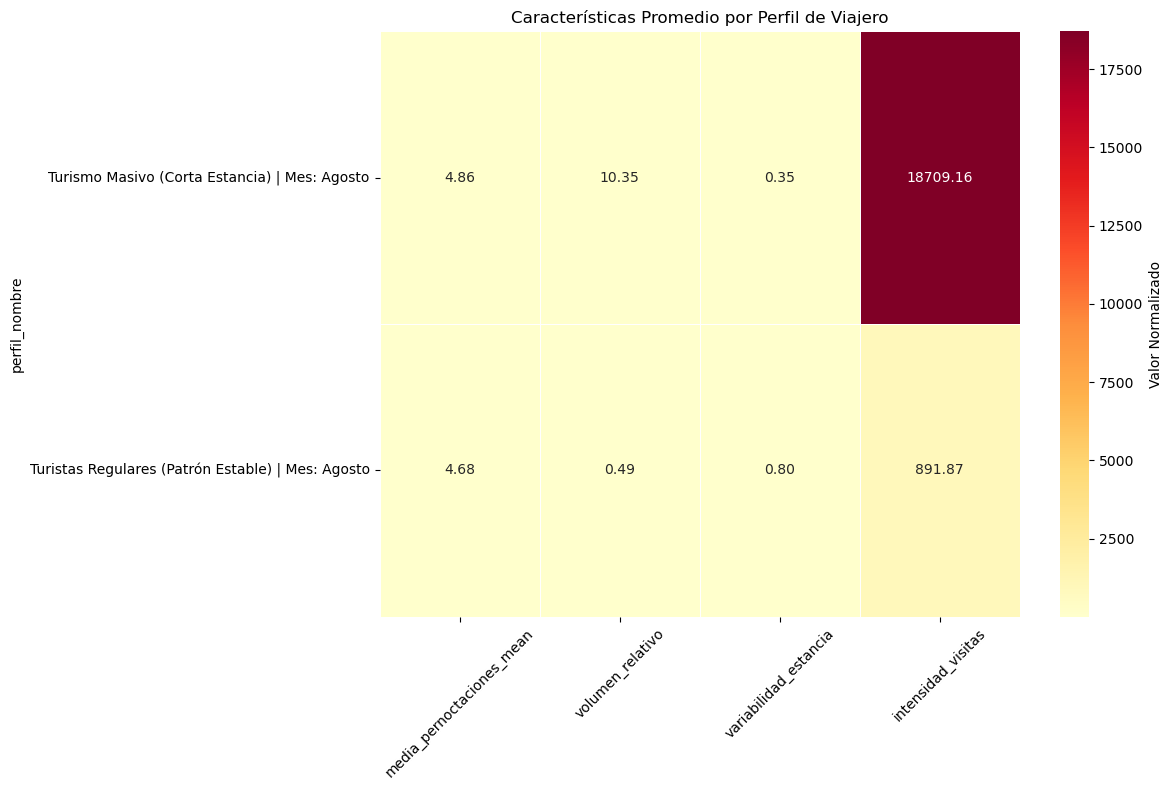

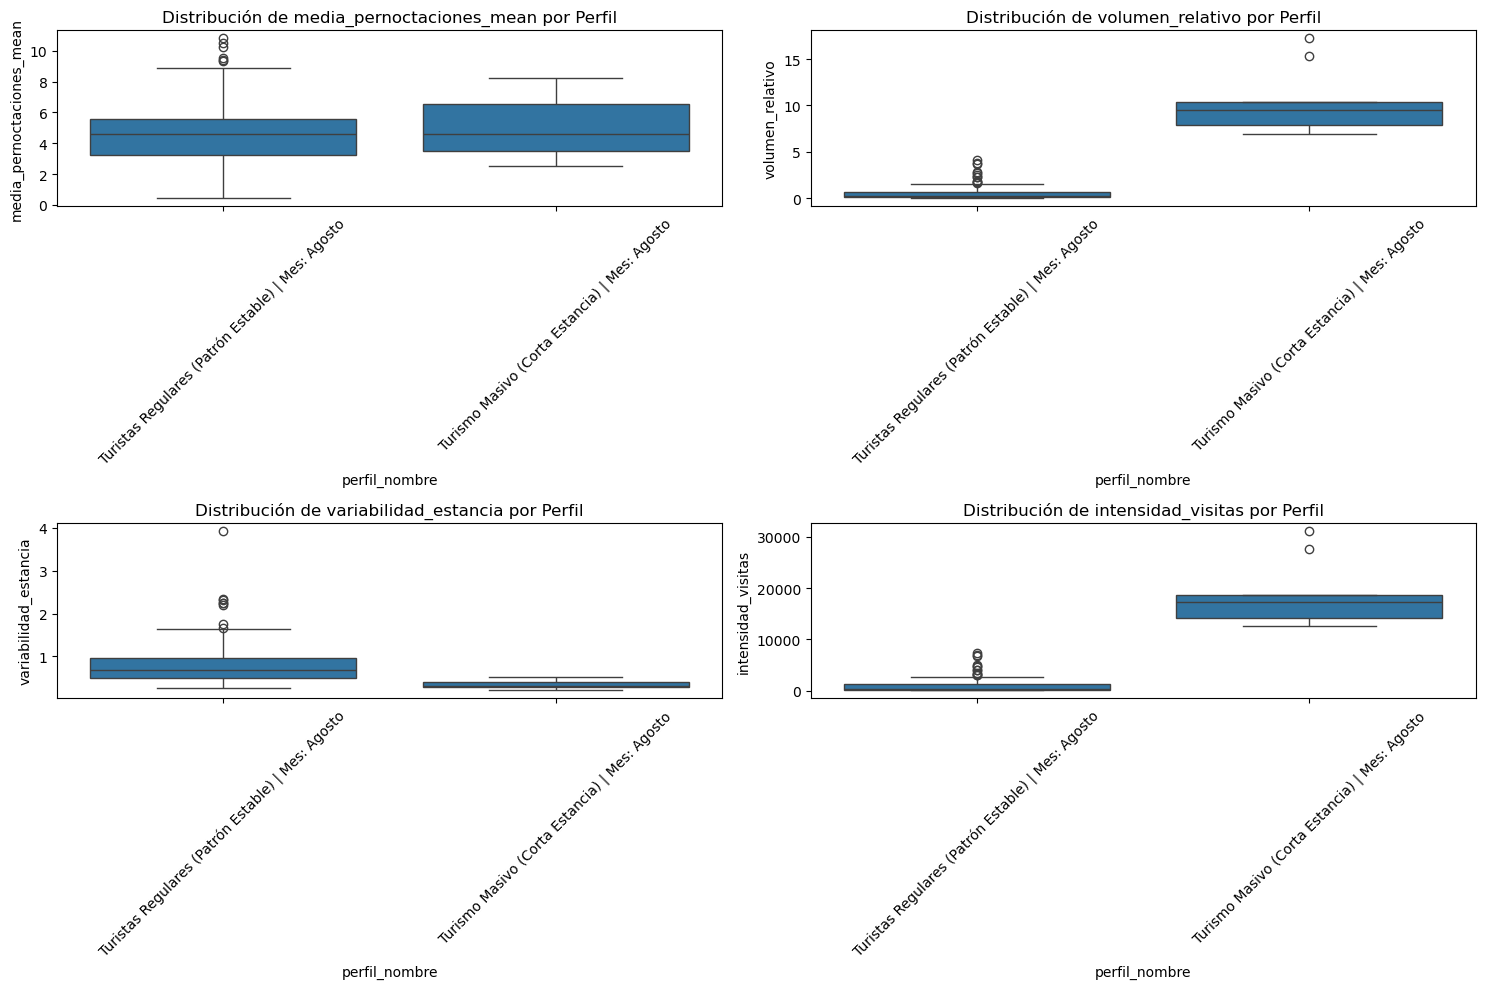

In [31]:
# Heatmap de características por cluster
plt.figure(figsize=(12, 8))
caracteristicas_heatmap = df_cluster.groupby('perfil_nombre')[
    ['media_pernoctaciones_mean', 'volumen_relativo', 
     'variabilidad_estancia', 'intensidad_visitas']
].mean()

sns.heatmap(caracteristicas_heatmap, annot=True, cmap='YlOrRd', fmt='.2f', 
            linewidths=0.5, cbar_kws={'label': 'Valor Normalizado'})
plt.title('Características Promedio por Perfil de Viajero')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Boxplot comparativo por cluster
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

metricas = ['media_pernoctaciones_mean', 'volumen_relativo', 
            'variabilidad_estancia', 'intensidad_visitas']

for i, metrica in enumerate(metricas):
    sns.boxplot(data=df_cluster, x='perfil_nombre', y=metrica, ax=axes[i])
    axes[i].set_title(f'Distribución de {metrica} por Perfil')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [32]:
# Análisis de composición por país en cada perfil
print("COMPOSICIÓN POR PAÍS EN CADA PERFIL:")
print("="*60)

for perfil in df_cluster['perfil_nombre'].unique():
    print(f"\n🔹 {perfil}:")
    perfil_data = df_cluster[df_cluster['perfil_nombre'] == perfil]
    
    # Top países en este perfil
    top_paises = perfil_data.groupby('pais_residencia').agg({
        'total_viajeros_sum': 'sum',
        'media_pernoctaciones_mean': 'mean',
        'provincia': 'count'
    }).nlargest(5, 'total_viajeros_sum')
    
    print(top_paises.round(2))
    print(f"Total segmentos: {len(perfil_data)}")
    print(f"Total viajeros: {perfil_data['total_viajeros_sum'].sum():,.0f}")

COMPOSICIÓN POR PAÍS EN CADA PERFIL:

🔹 Turistas Regulares (Patrón Estable) | Mes: Agosto:
                  total_viajeros_sum  media_pernoctaciones_mean  provincia
pais_residencia                                                           
Francia                    1758573.0                       4.88          7
Italia                     1302319.0                       5.38          7
Países Bajos               1216232.0                       4.95          7
Resto del mundo            1027811.0                       5.12          7
Resto de América            767303.0                       6.19          7
Total segmentos: 166
Total viajeros: 12,436,200

🔹 Turismo Masivo (Corta Estancia) | Mes: Agosto:
                 total_viajeros_sum  media_pernoctaciones_mean  provincia
pais_residencia                                                          
España                    8685586.0                       3.70          6
Reino Unido               4194176.0                       6.64  

In [33]:
# Encontrar ejemplos representativos de cada cluster (más cercanos al centroide)
print("EJEMPLOS REPRESENTATIVOS DE CADA PERFIL:")
print("="*65)

for cluster_id in sorted(df_cluster['cluster'].unique()):
    cluster_data = df_cluster[df_cluster['cluster'] == cluster_id]
    
    # Encontrar el punto más cercano al centroide
    representativo_idx = cluster_data['distancia_centroide'].idxmin()
    representativo = cluster_data.loc[representativo_idx]
    
    print(f"\n🎯 Perfil: {representativo['perfil_nombre']}")
    print(f"   Ejemplo representativo: {representativo['pais_residencia']} en {representativo['provincia']}")
    print(f"   - Estancia media: {representativo['media_pernoctaciones_mean']:.1f} noches")
    print(f"   - Volumen relativo: {representativo['volumen_relativo']:.2f}x promedio")
    print(f"   - Mes más probable: {representativo['mes_mas_probable']}")
    print(f"   - Total viajeros: {representativo['total_viajeros_sum']:,.0f}")

# Análisis de patrones geográficos por perfil
print("\n🔍 PATRONES GEOGRÁFICOS POR PERFIL:")
print("="*50)

for perfil in df_cluster['perfil_nombre'].unique():
    perfil_data = df_cluster[df_cluster['perfil_nombre'] == perfil]
    
    print(f"\n{perfil}:")
    provincias_count = perfil_data['provincia'].value_counts()
    print(f"  Provincias más comunes: {', '.join(provincias_count.head(3).index.tolist())}")

EJEMPLOS REPRESENTATIVOS DE CADA PERFIL:

🎯 Perfil: Turistas Regulares (Patrón Estable) | Mes: Agosto
   Ejemplo representativo: Portugal en Málaga
   - Estancia media: 5.0 noches
   - Volumen relativo: 0.33x promedio
   - Mes más probable: Agosto
   - Total viajeros: 49,491

🎯 Perfil: Turismo Masivo (Corta Estancia) | Mes: Agosto
   Ejemplo representativo: España en Islas Baleares
   - Estancia media: 4.6 noches
   - Volumen relativo: 9.53x promedio
   - Mes más probable: Agosto
   - Total viajeros: 1,447,253

🔍 PATRONES GEOGRÁFICOS POR PERFIL:

Turistas Regulares (Patrón Estable) | Mes: Agosto:
  Provincias más comunes: Barcelona, Girona, Madrid

Turismo Masivo (Corta Estancia) | Mes: Agosto:
  Provincias más comunes: Islas Baleares, Málaga, Girona


# Clusters con DBScan

In [34]:
# Aplicar DBSCAN para comparación
dbscan = DBSCAN(eps=0.8, min_samples=3)
dbscan_labels = dbscan.fit_predict(X_scaled)

df_cluster['dbscan_cluster'] = dbscan_labels

# Analizar resultados DBSCAN
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_ruido = list(dbscan_labels).count(-1)

print(f"\nDBSCAN - Clusters identificados: {n_clusters_dbscan}")
print(f"DBSCAN - Puntos considerados ruido: {n_ruido} ({n_ruido/len(dbscan_labels):.1%})")

# Comparar con K-Means
comparacion = pd.crosstab(df_cluster['cluster'], df_cluster['dbscan_cluster'])
print("\nComparación K-Means vs DBSCAN:")
print(comparacion)


DBSCAN - Clusters identificados: 9
DBSCAN - Puntos considerados ruido: 47 (26.9%)

Comparación K-Means vs DBSCAN:
dbscan_cluster  -1   0   1   2   3   4   5   6   7   8
cluster                                               
0               38  28   4  17  34  31   5   3   3   3
1                9   0   0   0   0   0   0   0   0   0


In [36]:
# Crear dataset final con perfiles
df_perfiles_final = df_cluster[[
    'pais_residencia', 'provincia', 'cluster', 'perfil_nombre',
    'media_pernoctaciones_mean', 'volumen_relativo', 'mes_mas_probable',
    'total_viajeros_sum', 'distancia_centroide'
]].sort_values(['cluster', 'total_viajeros_sum'], ascending=[True, False])

# Añadir recomendaciones basadas en perfil
def generar_recomendacion(perfil_nombre):
    if "Premium" in perfil_nombre:
        return "Enfoque en experiencias premium, servicios personalizados, paquetes de larga estancia"
    elif "Masivo" in perfil_nombre:
        return "Optimizar procesos, paquetes todo incluido, enfoque en eficiencia operativa"
    elif "Estacional" in perfil_nombre:
        return "Desarrollar ofertas fuera de temporada, programas de fidelización"
    elif "Larga" in perfil_nombre:
        return "Alojamientos con amenities prolongadas, partnerships con servicios locales"
    else:
        return "Estrategia balanceada, programas de fidelización, experiencias personalizables"

df_perfiles_final['recomendacion_estrategica'] = df_perfiles_final['perfil_nombre'].apply(generar_recomendacion)

print("RESUMEN FINAL DE PERFILES:")
print("="*50)
resumen_final = df_perfiles_final.groupby('perfil_nombre').agg({
    'total_viajeros_sum': 'sum',
    'pais_residencia': 'count',
    'media_pernoctaciones_mean': 'mean'
}).round(2)

resumen_final['%_total'] = (resumen_final['total_viajeros_sum'] / resumen_final['total_viajeros_sum'].sum() * 100).round(1)
print(resumen_final.sort_values('%_total', ascending=False))

# Exportar resultados
# df_perfiles_final.to_csv('perfiles_viajeros_clustering.csv', index=False, encoding='utf-8-sig')
# print("\n✅ Resultados exportados a 'perfiles_viajeros_clustering.csv'")

RESUMEN FINAL DE PERFILES:
                                                   total_viajeros_sum  \
perfil_nombre                                                           
Turismo Masivo (Corta Estancia) | Mes: Agosto              14144127.0   
Turistas Regulares (Patrón Estable) | Mes: Agosto          12436200.0   

                                                   pais_residencia  \
perfil_nombre                                                        
Turismo Masivo (Corta Estancia) | Mes: Agosto                    9   
Turistas Regulares (Patrón Estable) | Mes: Agosto              166   

                                                   media_pernoctaciones_mean  \
perfil_nombre                                                                  
Turismo Masivo (Corta Estancia) | Mes: Agosto                           4.86   
Turistas Regulares (Patrón Estable) | Mes: Agosto                       4.68   

                                                   %_total  
perfil_nombre    

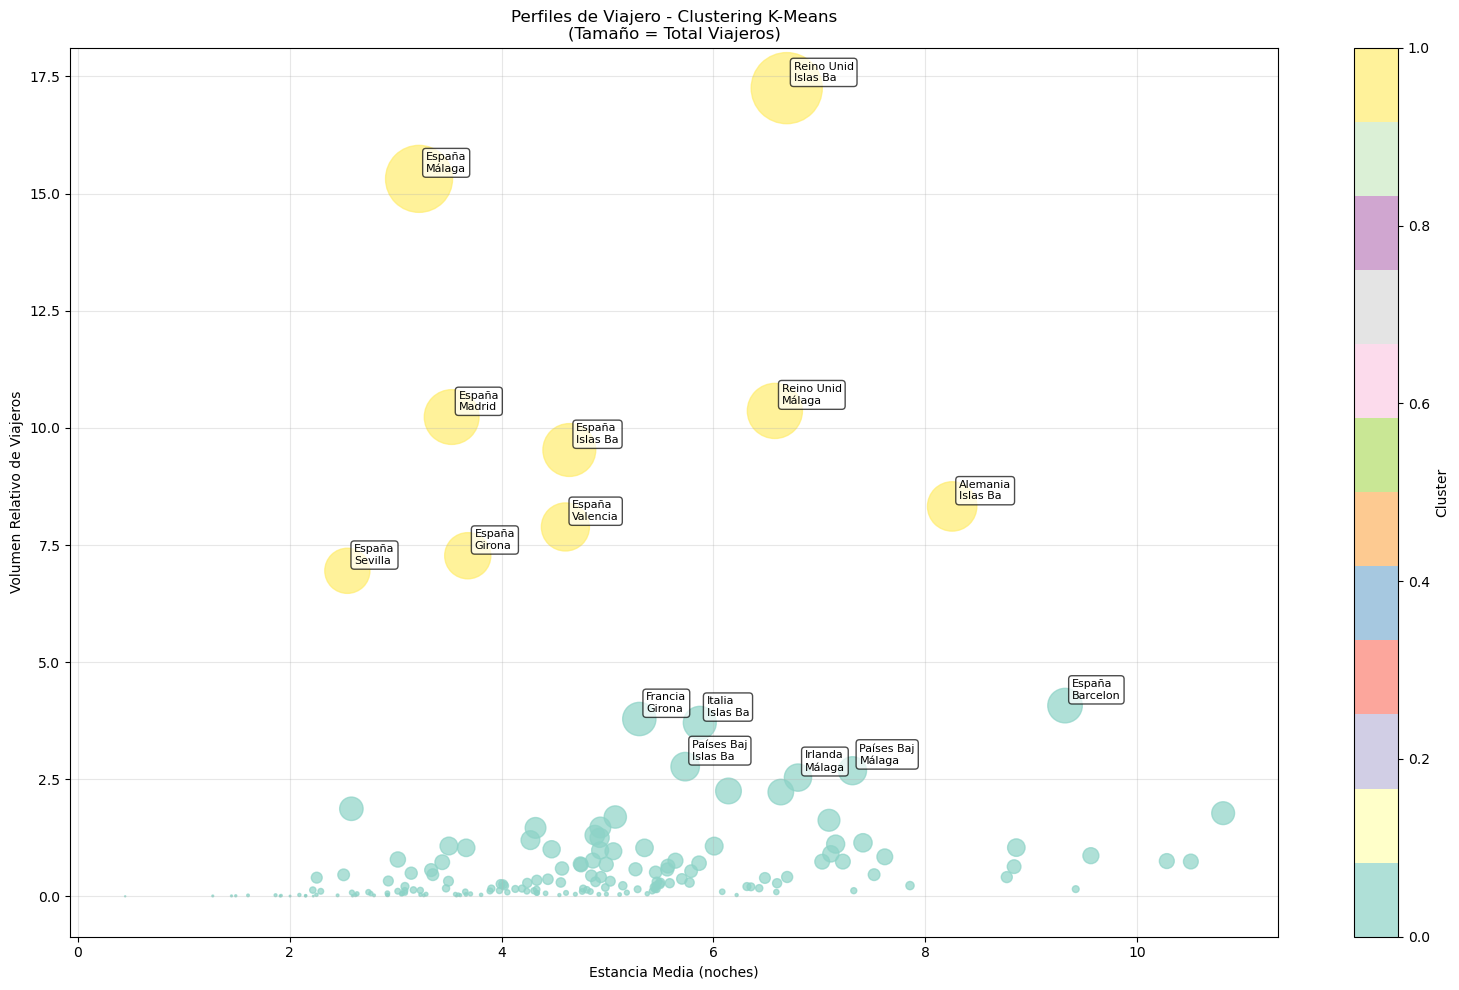

In [37]:
# Crear visualización interactiva de perfiles
plt.figure(figsize=(16, 10))

# Scatter plot con tamaño por volumen y color por cluster
scatter = plt.scatter(
    df_cluster['media_pernoctaciones_mean'],
    df_cluster['volumen_relativo'],
    c=df_cluster['cluster'],
    s=df_cluster['total_viajeros_sum']/1000,
    cmap='Set3',
    alpha=0.7
)

plt.colorbar(scatter, label='Cluster')
plt.xlabel('Estancia Media (noches)')
plt.ylabel('Volumen Relativo de Viajeros')
plt.title('Perfiles de Viajero - Clustering K-Means\n(Tamaño = Total Viajeros)')

# Anotar perfiles importantes
for i, row in df_cluster.nlargest(15, 'total_viajeros_sum').iterrows():
    plt.annotate(f"{row['pais_residencia'][:10]}\n{row['provincia'][:8]}", 
                (row['media_pernoctaciones_mean'], row['volumen_relativo']),
                xytext=(5, 5), textcoords='offset points', fontsize=8,
                bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.7))

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()